<a href="https://colab.research.google.com/github/HiuNgaiChan/3dSinGAN/blob/master/Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from scipy.stats import wasserstein_distance
import csv

def emd(p1, p2):
  return wasserstein_distance(p1, p2)

def min_mean_emd(real_p, fake_ps):
  emdList = []
  for i in fake_ps:
    emdList.append(emd(real_p, i))
  return min(emdList), sum(emdList)/len(emdList), emdList


def applyWeightstoDifferences(fake_mean_differences):
  for pointCloud in fake_mean_differences:
    w = 0.01
    for pointDiff in pointCloud:
      pointDiff = pointDiff * w
      w += 0.01

def findMeanPointCloud(fake_pcs):
  return np.mean(fake_pcs, axis = 0)


def findSumMeanDiff(fake_pts, mean_pts):
  #for each pont cloud, it performs generated_point_cloud - mean_point_cloud
  # and then sum the difference together into a single digit that represents 
  # the point cloud 


  batch_size = fake_pts.shape[0]
  outputArray = np.zeros((batch_size,1), dtype = np.float32)
  for count,points in enumerate(fake_pts):
    diff = np.sum(np.absolute(points - mean_pts))
    outputArray[count] = diff
  
  return outputArray

def checkUnique(fake_pts):

  meanPc = findMeanPointCloud(fake_pts).reshape(1,3000)
  smDiff = findSumMeanDiff(fake_pts, meanPc).reshape(fake_pts.shape[0])

  s = set()
  for i in smDiff:
    if i in s:
      return False
    else:
      s.add(i)
  return True

def mean_std(fake_pts):
  #This function is for returning the mean standard deviation
  meanPc = findMeanPointCloud(fake_pts).reshape(1,3000)
  cumulation = 0
  for i in fake_pts:
    temp = (i - meanPc)*(i - meanPc)
    temp = temp.reshape(1000,3)
    temp2 = np.sum(temp, axis = 1)
    temp3 = np.mean(temp2)
    cumulation += temp3

  return np.sqrt(cumulation/fake_pts.shape[0])

def findnnDistancePointWise(point, point_cloud):
  diff = 1000
  for i in point_cloud:
    if diff > np.absolute(i - point):
      diff = np.abosulute(i-point)


def squaredNNDistance(s_points, r_points):
  s_points_sum = np.zeros(1000)
  r_points_sum = np.zeros(1000)
  counter = 0
  for i in range(1000):
    s_points_sum[i] = s_points[counter] + s_points[counter+1] + s_points[counter+2]
    r_points_sum[i] = r_points[counter] + r_points[counter+1] + r_points[counter+2]
    counter += 3
  nnList = np.zeros(1000)
  clCounter = 0
  for s_point in s_points_sum:
    nnDistance = 1000
    for r_point in r_points_sum:
      if np.absolute(s_point-r_point) < nnDistance:
        nnDistance =  np.square(s_point-r_point)
    nnList[clCounter] = nnDistance
    clCounter += 1
    
  return np.sum(nnList)

def ChamferDistance(s_points, r_points):
  sToR = squaredNNDistance(s_points, r_points)
  rToS = squaredNNDistance(r_points, s_points)
  return sToR + rToS

def min_mean_CD(s_points_set, r_points):
  chamferList = np.zeros(s_points_set.shape[0])
  counter = 0
  for s_points in s_points_set:
    cd = ChamferDistance(s_points, r_points)
    chamferList[counter] = cd
    counter += 1

  return np.amin(chamferList), np.mean(chamferList)


if __name__ == "__main__":

  set_of_fake_pts=[]


  with open("monkey1000.csv", "r", newline = "") as originalFile:
    oreader = csv.reader(originalFile, delimiter=',', quotechar='|')
    referencePoints = []
    for line in oreader:
      for element in line:
        referencePoints.append(element)
  referencePoints = referencePoints[3:]
  referencePoints = np.asarray(referencePoints).astype(np.float32)


  for i in range(10):
    fileName = "vanilla1kMonkey" + str(i) + ".csv"
    with open(fileName, "r", newline="") as csvfile:
      reader = csv.reader(csvfile, delimiter=',', quotechar='|')
      pointList = []
      for line in reader:
        for element in line:
          pointList.append(element)
    set_of_fake_pts.append(pointList)

  np_fake_pts = np.asarray(set_of_fake_pts).astype(np.float32)


  #minemd, meanemd, _ = min_mean_emd(referencePoints, set_of_fake_pts)
  mincd, meancd = min_mean_CD(np_fake_pts, referencePoints)
  #print("Min-EMD: " + str(minemd) + "  Mean-EMD: " + str(meanemd) + " All unique: " + str(checkUnique(np_fake_pts))) 
  #print("mean_std: " + str(mean_std(np_fake_pts)))
  print("Min-CD: " + str(mincd) + " Mean-CD: " + str(meancd))


Min-CD: 2.6057666190425097 Mean-CD: 3.456776254530811


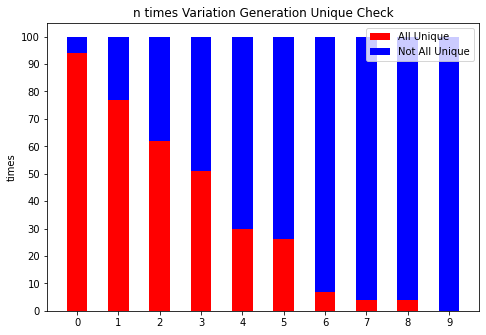

In [18]:
import numpy as np
import matplotlib.pyplot as plt
N = 10
true = (94, 77, 62, 51, 30, 26, 7, 4, 4, 0)
false = (6, 23, 38, 49, 70, 74, 93, 96, 96, 100)
ind = np.arange(N) # the x locations for the groups
width = 0.5
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, true, width, color='r')
ax.bar(ind, false, width,bottom=true, color='b')
ax.set_ylabel('times')
ax.set_title('n times Variation Generation Unique Check')
ax.set_xticks(ind)
ax.set_yticks(np.arange(0, 110, 10))
ax.legend(labels=['All Unique', 'Not All Unique'])
plt.show()